In [17]:
import pennylane as qml
from pennylane import CVNeuralNetLayers
from pennylane.optimize import AdamOptimizer
import numpy as np
from functools import reduce
from tqdm import tqdm
import dill
from matplotlib import pyplot as plt
import torch
from torch.optim import Adam
import random

In [18]:
wires = 4
layers = 2

epoch = 20*50
batch_size = 10

weights = torch.rand((layers, 3*wires), requires_grad=True)
rotations = torch.rand((layers, wires), requires_grad=True)

dev = qml.device('default.mixed', wires=wires)

print(dev)

Default mixed-state qubit PennyLane plugin
Short name: default.mixed
Package: pennylane
Plugin version: 0.36.0
Author: Xanadu Inc.
Wires: 4
Shots: None


### Accuracy
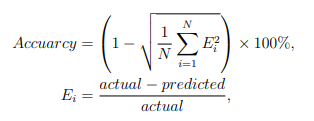

In [19]:
def accuracy(predicted_sequence, true_sequence):
    return 1-np.sqrt(np.mean( np.square((predicted_sequence - true_sequence)/true_sequence) ))

In [20]:
def ansatz(weights, rotations, depth = 4, layer = 1):
  for i in range(layer):
    for j in range(depth):
      qml.RX(weights[i, 3*j],   j)
      qml.RZ(weights[i, 3*j+1], j)
      qml.RX(weights[i, 3*j+2], j)
      
    for a in range(depth-1):
      qml.CNOT(wires=[a, a+1])
      qml.RZ(rotations[i, a], a+1)
      qml.CNOT(wires=[a, a+1])
    
    qml.CNOT(wires=[depth-1, 0])
    qml.RZ(rotations[i, -1], 0)
    qml.CNOT(wires=[depth-1, 0])
  
def encode_x(x, depth = 4):
  for i in range(depth//2):
    qml.RY(torch.arccos(x), i)

def init_hidden_state(depth = 4):
  for i in range(depth//2, depth):
    qml.RY(torch.arccos(torch.zeros(1)), i)
  

@qml.qnode(dev, diff_method="backprop", interface='torch')
def circuit(weights, rotations, x, measurments, density_matrix_hidden):
  """
  Measurnemnt needs to be passed by reference
  
  Return output and current hidden state
  """
  qml.QubitDensityMatrix(density_matrix_hidden, wires=list(range(wires//2, wires)))
  encode_x(x, depth=wires)
  ansatz(weights, rotations, depth=wires, layer=layers)
  out = qml.density_matrix(list(range(wires)))
  
  return out

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return (labels - predictions) ** 2
  
Z = torch.Tensor([[1, 0], [0, -1]]).to(dtype=torch.complex128)
X = torch.Tensor([[0, 1], [1, 0]]).to(dtype=torch.complex128)
I = torch.eye(2).to(dtype=torch.complex128)
measurment_operator = torch.kron(Z, Z)
measurment_operator_full = torch.kron(torch.kron(Z, Z), torch.kron(I, I))

def measure_ZZ(density_matrix, x_dimension=2):
  """
  1. trace out the 2nd subsystem then perform measurments
  
  Returns the expectation value from ZZ measurment
  """
  reduced_density_matrix = np.einsum('jiki->jk', density_matrix.view(2**(wires//2), 2**(wires//2), 2**(wires//2), 2**(wires//2)))

  return torch.trace(measurment_operator @ reduced_density_matrix)

def project_density_matrix(density_matrix):
  """

  Returns:
      Partial traced mixed density matrix of shape (2**(wires//2), 2**(wires//2))
  """
  rho = (measurment_operator_full @ density_matrix).view(2**(wires//2), 2**(wires//2), 2**(wires//2), 2**(wires//2))
  return torch.einsum('ijik->jk', rho)



def cost(weights, rotations, X, density_matrix):
    loss = 0
    for xs, label in X:
      measurnemt = []
      # Clone initial density matrix
      rho = density_matrix.clone()
      for x in xs:
        out_density = circuit(weights, rotations, x, measurnemt, rho)
        prediction = measure_ZZ(out_density).to(torch.float)
        rho = project_density_matrix(out_density)/prediction
        
      loss += square_loss(label, prediction)
    
    return loss/batch_size


In [22]:

train, test = dill.load(open('temperature_processed.pkl', 'rb'))
train, test = train[:500], test[:500]

optimizer = Adam([weights, rotations], lr=0.001)

### Prepare state with all zeros ex. |0000>
zero_state = 1/2 * (I + X)
one_state = 1/2 * (I - X)

density_matrix = torch.kron(zero_state, one_state)
for _ in range(wires-2):
  density_matrix = torch.kron(density_matrix, zero_state)

loss_history = []

print(measure_ZZ(density_matrix))
print(project_density_matrix(density_matrix))



def closure():
    batch = random.choices(train, k=batch_size)
    optimizer.zero_grad()
    loss = cost(weights, rotations, batch, density_matrix)
    loss.backward()
    
    return loss
  
loss_history = []
for i in tqdm(range(epoch)):
  loss = optimizer.step(closure)
  loss_history.append(loss.item())
  
  if i % 500 == 0:
    print(loss.item())

dill.dump((weights, rotations), open('params.pkl', 'wb'))

plt.plot(loss_history)
plt.yscale('log')
plt.show()



tensor(0.+0.j, dtype=torch.complex128)
tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]], dtype=torch.complex128)


  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Density matrix must be of length (2**wires, 2**wires)

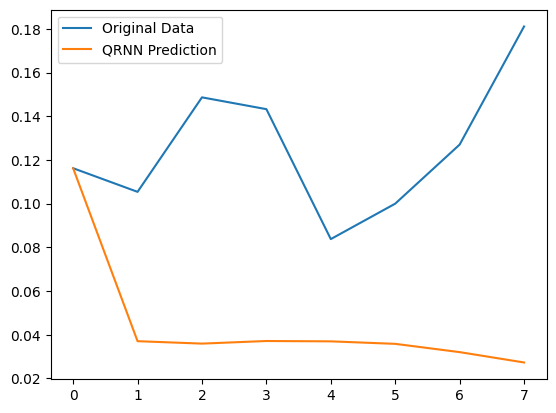

In [ ]:
### Show example

weights, rotations = dill.load(open('params.pkl', 'rb'))

xs = torch.cat((test[0][0], test[0][1]))
plt.plot(xs, label='Original Data')

#print(cost(weights, rotations, test))
with torch.no_grad():
  predictions = [test[0][0][0]]
  hidden_state = torch.zeros((1,))
  rho = density_matrix.clone()
  for x in test[0][0]:
    out_density = circuit(weights, rotations, x, [], rho)
    prediction = measure_ZZ(out_density).to(torch.float)
    rho = project_density_matrix(out_density)/prediction
    predictions.append(prediction)
  
  plt.plot(predictions, label='QRNN Prediction')
plt.legend()
plt.show()